In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

# Language Recognition

## Language Recognition

**Let's consider the following problem:**

* Given a short piece of text (e.g. a sentence)
* We want to determine in which language it is written (English/French/Italian)

Some examples:

> The doctor, who was the family physician, saluted him, but he scarcely took any notice. **--> English**

> J'ai couru chez toi, je ne t'ai plus trouvée, tu sais la parole que je t'avais donnée, je la Bens. **--> French**

> Conosci tu qualche hossanieh poco scrupoloso che si possa comperare con un bel pugno d'oro? **--> Italian**

## A Look at the Data

**We can find the data for this problem in the `data` folder**

In [2]:
!ls data

lr_test.txt  lr_train.txt  real_estate.csv  weather.csv


* Specifically, we care about the `lr_train.txt` and `lr_test.txt` files
* Let's have a look at their content:

In [3]:
with open('data/lr_train.txt') as fp:
    lines = fp.readlines()[:4]
    print('\n'.join(lines))

The doctor, who was the family physician, saluted him, but he scarcely took any notice.@english

Cette réserve faite, et faite en toute sévérité, il nous est impossible de ne pas admirer, qu'ils réussissent ou non, les glorieux combattants de l'avenir, les confesseurs de l'utopie.@french

"I have often wondered," he said, "why there was a kind of a Christian air about this one confectioner's shop.@english

Ammantellato accuratamente, egli passeggiava innanzi e indietro, colla testa china sul petto, la fronte aggrottata e gli occhi accesi da una cupa fiamma.@italian



## Feature Extraction

**This is raw text data**

How can we deal that using a linear model?

* We need to find a _numeric encoding_
* ...But a one-hot encoding will not longer be enough

**The traditional approach in this situation consist in:**

* Applying algorithms to the data in order to extract numerical _features_
* Use the features as input for the linear model

**The task of finding good features is also known as _feature engineering_**

It is a critical step in classical Machine Learning

* Good features will lead to good results and vice-versa
* It can also be a challenging task!

The success of Deep Learning is partly due to the possibility to skip this step

## Loading the Data

**We will rely on a custom module**

...This is called `util.pyu` and is available in the `util` folder

In [4]:
!ls util

__init__.py  __pycache__  util.py


From the module, we call the `load_lr_data` function:

In [5]:
from util import util

text_train, lang_train = util.load_lr_data('data/lr_train.txt')
text_test, lang_test = util.load_lr_data('data/lr_test.txt')

for text, lang in zip(text_train[:3], lang_train[:3]):
    print(f'{text} --> {lang}')

The doctor, who was the family physician, saluted him, but he scarcely took any notice. --> english
Cette réserve faite, et faite en toute sévérité, il nous est impossible de ne pas admirer, qu'ils réussissent ou non, les glorieux combattants de l'avenir, les confesseurs de l'utopie. --> french
"I have often wondered," he said, "why there was a kind of a Christian air about this one confectioner's shop. --> english


## Feature Extraction in Practice

**We can build a function to process all pieces of text**

* For each piece of text, we will run simple algorithms and extract numeric features
* These features specifically are _not very good_
* Later, we will work to improve them!

We call the function for both our training and test data

In [6]:
import pandas as pd
import numpy as np
import unidecode
from sklearn.preprocessing import StandardScaler

# Here is a list of all separators found in the data
separators = ['(', '«', ',', '»', u"'", '+', '/', '°', ';', '?', '[', '_', ' ', '\n', '"', '&', '*', '.', ':', '\t', '!', ')', '-', 'º', ']', ]
separators_as_string = ''.join(separators)

def extract_features(text):
    # Prepare a data structure to store the results
    res = []
    names = []
    # Loop over all pieces of text
    for cnt, lne in enumerate(text):
        # PREPARE A ROW FOR THE DATASET
        row = []
        # Obtain the list of words (this is useful to extract many features)
        words = [w.strip(separators_as_string) for w in lne.split()]
        words = [w for w in words if len(w) > 0]

        # EXTRACT FEATURES
        # F0: Number of words
        nwords = len(words)
        row.append(nwords)
        if cnt == 0: names.append('nwords')
        # F1: Number of characters per word
        row.append(len(lne) / nwords)
        if cnt == 0: names.append('ncpw')
        # F2: Get number of vowels
        # NOTE: "lower()" makes the string lower case
        nvowels = len([c for c in lne if c.lower() in ('a', 'e', 'i', 'o', 'u', 'y')])
        row.append(nvowels)
        if cnt == 0: names.append('nvowels')
        # F3: Get the number of words starting with "p"
        nstartp = len([w for w in words if w[0] == 'p'])
        row.append(nstartp)
        if cnt == 0: names.append('nstartp')
        # F4: Get number of occurrences of either "cookie" or "wookie"
        ncwookie = len([w for w in words if w in ['cookie', 'wookie']])
        row.append(ncwookie)
        if cnt == 0: names.append('ncwookie')
        
        # APPEND THE ROW
        res.append(row)
    # Return the result
    return pd.DataFrame(columns=names, data= res)


x_train = extract_features(text_train)
x_test = extract_features(text_test)

# Rescale
scaler = StandardScaler()
x_train = pd.DataFrame(columns=x_train.columns, data=scaler.fit_transform(x_train))
x_test = pd.DataFrame(columns=x_test.columns, data=scaler.transform(x_test))

## Feature Extraction in Practice

**We can now have a look at the result**

In [7]:
for text in text_train[:5]: print(text)
display(x_train.head())

The doctor, who was the family physician, saluted him, but he scarcely took any notice.
Cette réserve faite, et faite en toute sévérité, il nous est impossible de ne pas admirer, qu'ils réussissent ou non, les glorieux combattants de l'avenir, les confesseurs de l'utopie.
"I have often wondered," he said, "why there was a kind of a Christian air about this one confectioner's shop.
Ammantellato accuratamente, egli passeggiava innanzi e indietro, colla testa china sul petto, la fronte aggrottata e gli occhi accesi da una cupa fiamma.
--Tu mi chiedevi il perchè ti seppellii in quest'inferno, diss'egli, calcando su ogni parola.


,nwords,ncpw,nvowels,nstartp,ncwookie
0,-0.781330,-0.207766,-0.801322,-0.188279,0.0
1,0.605359,0.633761,0.649457,-0.188279,0.0
2,-0.286084,-0.671139,-0.473727,-0.921664,0.0
3,0.011063,1.108481,0.509059,0.545107,0.0
4,-0.880380,1.094091,-0.707723,0.545107,0.0


* We now have a usable dataset!
* Just don't count on the initial feature to be any good ;-)

## Multinomial/Multiclass Classification

**We now need to take care of the targets**

...Which in a classification setting are often referred to as _labels_

* Unlike in the previous example, we have three classes
* ...Wich makes this a _multinomial (or multiclass) classification_ task

**We can deal with that by:**

* Introducing _one separate Logistic Regression model per class_
  - Hence, in our case we will have three models and three outputs
  - Normalize the outputs over their sum, so they can be seen as a probability distribution
* Using the categorical (rather than binomial) crossentropy as loss function

**Fortunately, scikit-learn takes care of all these steps for us**

We just need to add the class as an integer (or categorical) attribute:

In [8]:
lang_train = pd.Series(lang_train).astype('category')
lang_test = pd.Series(lang_test).astype('category')

## Multinomial Logistic Regression in Practice

**We will train a Logistic Regression model with L1 regularization**

...And we will use grid search + cross-validation to tune the reguralizer weight

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

m = LogisticRegression(penalty='l1', C=1.0, solver='saga', tol=0.01)
param_grid = {'C': np.logspace(-2, 2, 10)}
gscv = GridSearchCV(estimator=m, param_grid=param_grid, cv=5)
gscv.fit(x_train, lang_train);

* The `C` parameter is the inverse of the reguralizer weight
* We use the [SAGA](https://arxiv.org/abs/1407.0202) since the default one does not support L1 reguralization
* We reduce the tolerance to 0.01 to reach convergence within the default iteration limit

Then we can inspect the value of the best parameter and otbain 

In [10]:
gscv.best_params_

{'C': 0.5994842503189409}

## Evaluation

**We can now obtain the predictions and evaluate the model (on the test set)**

Accuracy on the test set: 0.688


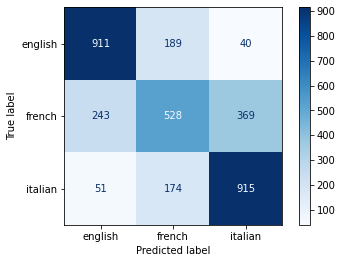

In [11]:
from sklearn.metrics import accuracy_score
y_pred_ts = gscv.predict(x_test)
print(f'Accuracy on the test set: {accuracy_score(lang_test, y_pred_ts):.3}')

from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(gscv, x_test, lang_test, display_labels=lang_test.cat.categories, cmap='Blues');

## Evaluation

**Since we used L1 regularization & rescaling, we can interpret the coeffients**

We have one coefficient per input and per output:

In [12]:
gscv.best_estimator_.coef_

array([[ 4.64256925,  0.27477344, -4.79643806, -0.78025923,  0.        ],
       [ 0.3681185 ,  0.24499123, -0.34138512,  0.39356257,  0.        ],
       [-5.26894813, -0.65402602,  5.41669465,  0.10795159,  0.        ]])

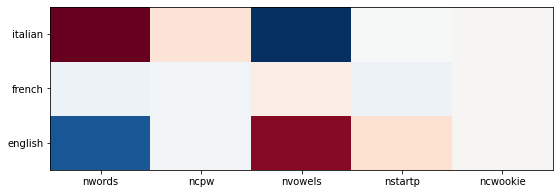

In [13]:
from matplotlib import pyplot as plt
n = len(x_train.columns)
plt.figure(figsize=(9,3))
plt.pcolor(gscv.best_estimator_.coef_, cmap='RdBu')
plt.xticks(0.5 + np.arange(len(x_train.columns)), x_train.columns);
plt.yticks(0.5 + np.arange(len(lang_train.cat.categories)), lang_train.cat.categories);

# Let's Put Everything Together

## Let's Put Everything Together

**Finally, we can put everything together**

We can improve our model by:

* Extracting features
* Training a model (and calibrating $C$)
* Checking _which kind of mistakes we are making_
* Checking _which features are actually useful_

...And the using the collected information to devise new features!

**You can find the process for a whole iteration in a single cell, for convenience:** 

Accuracy on the test set: 0.688


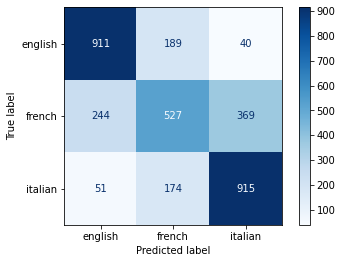

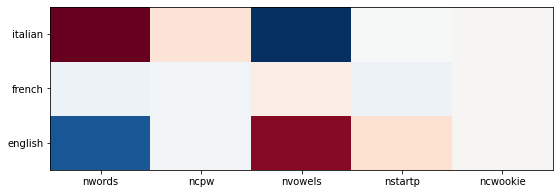

In [14]:
def extract_features(text):
    # Prepare a data structure to store the results
    res = []
    names = []
    # Loop over all pieces of text
    for cnt, lne in enumerate(text):
        # PREPARE A ROW FOR THE DATASET
        row = []
        # Obtain the list of words (this is useful to extract many features)
        words = [w.strip(separators_as_string) for w in lne.split()]
        words = [w for w in words if len(w) > 0]

        # EXTRACT FEATURES
        # F0: Number of words
        nwords = len(words)
        row.append(nwords)
        if cnt == 0: names.append('nwords')
        # F1: Number of characters per word
        row.append(len(lne) / nwords)
        if cnt == 0: names.append('ncpw')
        # F2: Get number of vowels
        # NOTE: "lower()" makes the string lower case
        nvowels = len([c for c in lne if c.lower() in ('a', 'e', 'i', 'o', 'u', 'y')])
        row.append(nvowels)
        if cnt == 0: names.append('nvowels')
        # F3: Get the number of words starting with "p"
        nstartp = len([w for w in words if w[0] == 'p'])
        row.append(nstartp)
        if cnt == 0: names.append('nstartp')
        # F4: Get number of occurrences of either "cookie" or "wookie"
        ncwookie = len([w for w in words if w in ['cookie', 'wookie']])
        row.append(ncwookie)
        if cnt == 0: names.append('ncwookie')
        
        # APPEND THE ROW
        res.append(row)
    # Return the result
    return pd.DataFrame(columns=names, data= res)


x_train = extract_features(text_train)
x_test = extract_features(text_test)

# Rescale
scaler = StandardScaler()
x_train = pd.DataFrame(columns=x_train.columns, data=scaler.fit_transform(x_train))
x_test = pd.DataFrame(columns=x_test.columns, data=scaler.transform(x_test))

# Train a model and calibrate the reguralizer weight
m = LogisticRegression(penalty='l1', C=1.0, solver='saga', tol=0.01)
param_grid = {'C': np.logspace(-2, 2, 10)}
gscv = GridSearchCV(estimator=m, param_grid=param_grid, cv=5)
gscv.fit(x_train, lang_train);


# Evaluation
y_pred_ts = gscv.predict(x_test)
print(f'Accuracy on the test set: {accuracy_score(lang_test, y_pred_ts):.3}')

plot_confusion_matrix(gscv, x_test, lang_test, display_labels=lang_test.cat.categories, cmap='Blues')

n = len(x_train.columns)
plt.figure(figsize=(9,3))
plt.pcolor(gscv.best_estimator_.coef_, cmap='RdBu')
plt.xticks(0.5 + np.arange(len(x_train.columns)), x_train.columns);
plt.yticks(0.5 + np.arange(len(lang_train.cat.categories)), lang_train.cat.categories);